# XAI Analysis: Explaining Higgs Boson Predictions

This notebook applies various Explainable AI (XAI) methods to understand model predictions:
- SHAP (SHapley Additive exPlanations)
- LIME (Local Interpretable Model-agnostic Explanations)
- Integrated Gradients
- DeepLIFT
- Gradient SHAP

In [1]:
import sys
sys.path.append('../src')

import torch
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from data_loader import load_higgs_data, get_feature_names
from models import create_model
from xai_methods import XAIAnalyzer
from visualization import plot_attribution_heatmap

%matplotlib inline

## Configuration

In [2]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Configuration
config = {
    'model_type': 'simple',
    'model_path': '../models/higgs_classifier_simple.pth',
    'n_test_samples': 500  # Number of test samples to analyze
}

Using device: cpu


## Load Data and Model

In [3]:
# Load data
X_train, X_test, y_train, y_test = load_higgs_data(
    data_path='../data/HIGGS.csv',
    n_samples=50000,
    test_split=0.2,
    random_seed=42
)

feature_names = get_feature_names()

# Use subset for faster XAI computation
X_test_subset = X_test[:config['n_test_samples']]
y_test_subset = y_test[:config['n_test_samples']]

print(f"Training samples: {len(X_train)}")
print(f"Test samples for XAI: {len(X_test_subset)}")
print(f"Number of features: {X_train.shape[1]}")

Loading data from ../data/HIGGS.csv...
Loaded 40000 training samples and 10000 test samples
Number of features: 28
Class distribution - Train: 53.21% signal
Class distribution - Test: 52.82% signal
Training samples: 40000
Test samples for XAI: 500
Number of features: 28


In [4]:
# Load model
input_dim = X_train.shape[1]
model = create_model(
    model_type=config['model_type'],
    input_dim=input_dim
)

# Try to load trained weights, otherwise use untrained model
try:
    model.load_state_dict(torch.load(config['model_path'], map_location=device))
    print(f"Loaded model from {config['model_path']}")
except FileNotFoundError:
    print(f"Model file not found at {config['model_path']}")
    print("Using untrained model for demonstration purposes")

model.to(device)
model.eval()

print(f"\nModel parameters: {sum(p.numel() for p in model.parameters())}")

Loaded model from ../models/higgs_classifier_simple.pth

Model parameters: 4161


## Initialize XAI Analyzer

In [5]:
# Create XAI analyzer
xai_analyzer = XAIAnalyzer(
    model=model,
    feature_names=feature_names,
    device=device
)

print("XAI Analyzer initialized")

XAI Analyzer initialized


## 1. SHAP Analysis

SHAP (SHapley Additive exPlanations) provides a unified measure of feature importance based on game theory.

In [6]:
print("Computing SHAP values...")
shap_values, shap_explainer = xai_analyzer.compute_shap_values(
    X_background=X_train,
    X_test=X_test_subset,
    n_background=100
)

print(f"SHAP values shape: {shap_values.shape}")

Computing SHAP values...
Background shape: (100, 28)
Test shape: (500, 28)
Raw SHAP values shape: (500, 28, 1)
SHAP values type: <class 'numpy.ndarray'>
SHAP values shape: (500, 28, 1)


Detected 3D SHAP values: (500, 28, 1)
Squeezed to 2D: (500, 28)


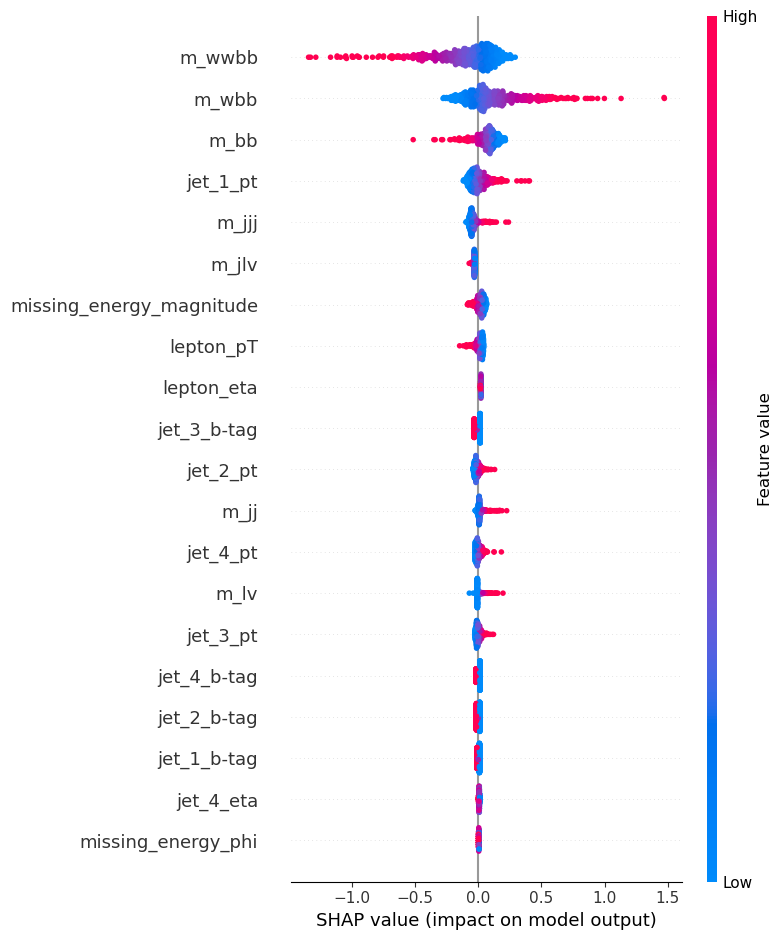

In [7]:
# Plot SHAP summary
xai_analyzer.plot_shap_summary(
    shap_values,
    X_test_subset,
    max_display=20,
    save_path='../figures/shap_summary.png'
)

Detected 3D SHAP values: (500, 28, 1)
Squeezed to 2D: (500, 28)
Detected 3D test data: (500, 28, 1)
Squeezed to 2D: (500, 28)


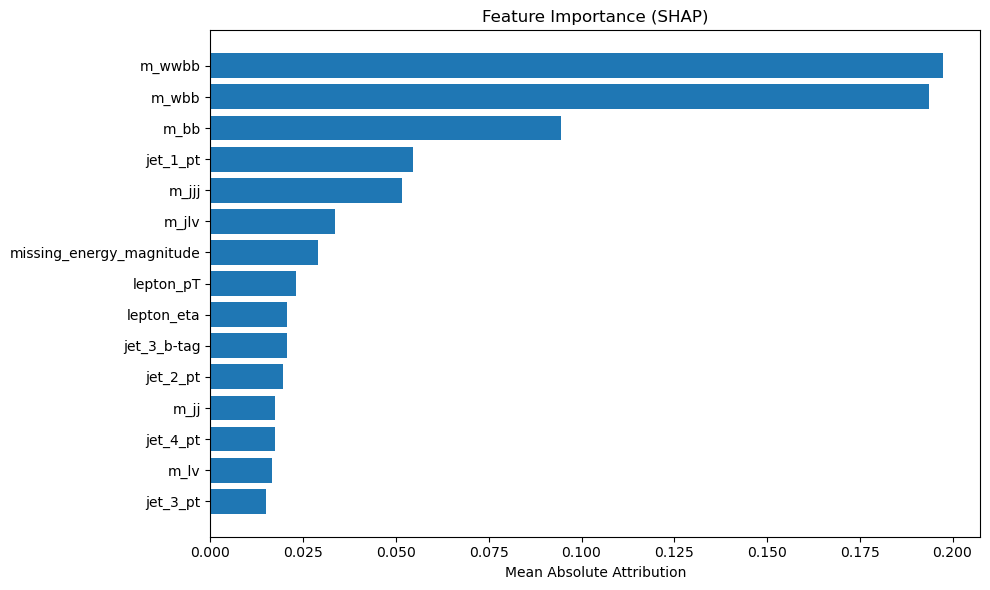

In [8]:
# Plot feature importance from SHAP
xai_analyzer.plot_feature_importance(
    shap_values,
    top_k=15,
    title='Feature Importance (SHAP)',
    save_path='../figures/shap_importance.png'
)

## 2. LIME Analysis

LIME explains individual predictions by learning an interpretable model locally around the prediction.

In [9]:
# Select a few interesting examples
# Get signal and background examples
signal_idx = np.where(y_test_subset == 1)[0][0]
background_idx = np.where(y_test_subset == 0)[0][0]

print(f"Analyzing signal example at index {signal_idx}")
lime_exp_signal = xai_analyzer.compute_lime_explanation(
    X_train=X_train,
    X_instance=X_test_subset[signal_idx],
    num_features=10
)

print("\nTop features for signal prediction:")
for feature, weight in lime_exp_signal['feature_weights']:
    print(f"  {feature}: {weight:.4f}")

Analyzing signal example at index 0

Top features for signal prediction:
  m_wwbb <= -0.60: 0.2129
  -0.19 < m_bb <= 0.32: 0.1178
  jet_1_pt <= -0.66: -0.0784
  m_jj <= -0.37: -0.0548
  -0.58 < m_wbb <= -0.23: -0.0543
  jet_4_pt > 0.46: 0.0408
  m_lv > -0.18: 0.0398
  -0.20 < m_jjj <= 0.17: -0.0363
  -0.71 < missing_energy_magnitude <= -0.18: 0.0340
  jet_2_pt <= -0.67: -0.0246


In [10]:
print(f"\nAnalyzing background example at index {background_idx}")
lime_exp_background = xai_analyzer.compute_lime_explanation(
    X_train=X_train,
    X_instance=X_test_subset[background_idx],
    num_features=10
)

print("\nTop features for background prediction:")
for feature, weight in lime_exp_background['feature_weights']:
    print(f"  {feature}: {weight:.4f}")


Analyzing background example at index 2

Top features for background prediction:
  m_wwbb > 0.32: -0.2776
  m_bb > 0.32: -0.2485
  m_wbb > 0.29: 0.1856
  jet_1_pt > 0.39: 0.1363
  -0.48 < m_jjj <= -0.20: -0.0456
  jet_4_pt > 0.46: 0.0371
  jet_2_pt > 0.42: 0.0338
  jet_3_pt > 0.46: 0.0333
  lepton_pT <= -0.70: 0.0332
  lepton_eta <= -0.74: -0.0234


## 3. Integrated Gradients

Integrated Gradients attributes the prediction to input features by integrating gradients along a path from a baseline.

In [11]:
print("Computing Integrated Gradients...")
ig_attributions = xai_analyzer.compute_integrated_gradients(
    X_test=X_test_subset,
    n_steps=50
)

print(f"IG attributions shape: {ig_attributions.shape}")

Computing Integrated Gradients...
IG attributions shape: (500, 28)


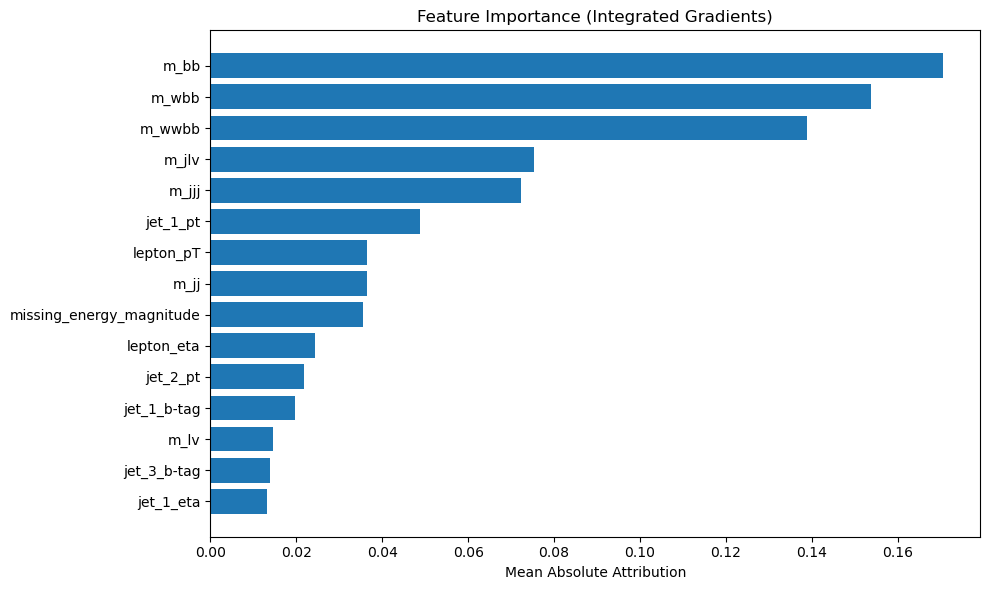

In [12]:
# Plot feature importance from Integrated Gradients
xai_analyzer.plot_feature_importance(
    ig_attributions,
    top_k=15,
    title='Feature Importance (Integrated Gradients)',
    save_path='../figures/ig_importance.png'
)

## 4. DeepLIFT

DeepLIFT compares the activation of each neuron to its reference activation.

In [13]:
print("Computing DeepLIFT attributions...")
deeplift_attributions = xai_analyzer.compute_deeplift(
    X_test=X_test_subset
)

print(f"DeepLIFT attributions shape: {deeplift_attributions.shape}")

Computing DeepLIFT attributions...
DeepLIFT attributions shape: (500, 28)


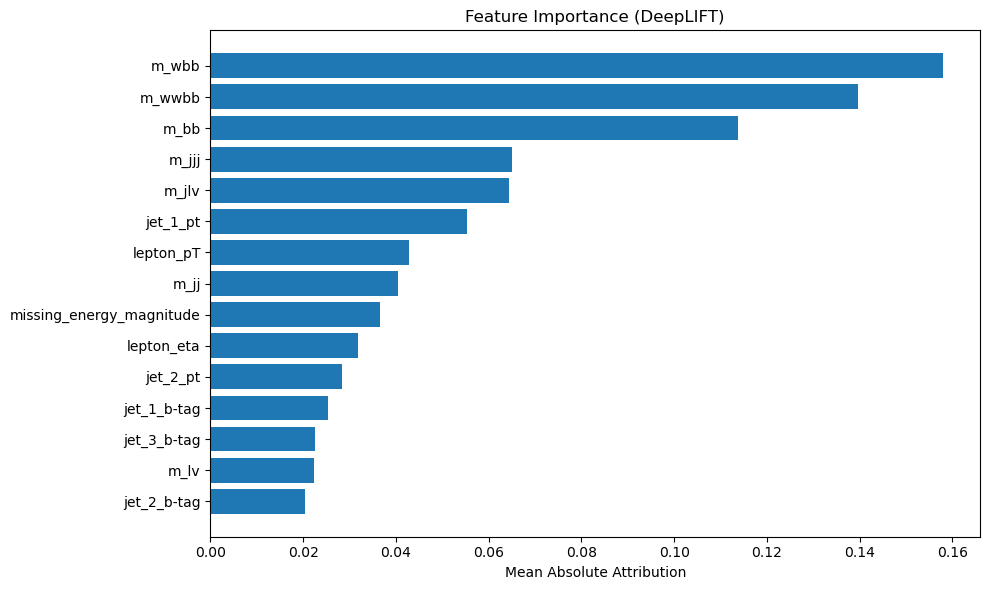

In [14]:
# Plot feature importance from DeepLIFT
xai_analyzer.plot_feature_importance(
    deeplift_attributions,
    top_k=15,
    title='Feature Importance (DeepLIFT)',
    save_path='../figures/deeplift_importance.png'
)

## 5. Compare XAI Methods

Compare all XAI methods side by side.

Computing SHAP values...
Background shape: (100, 28)
Test shape: (100, 28)
Raw SHAP values shape: (100, 28, 1)
SHAP values type: <class 'numpy.ndarray'>
Computing Integrated Gradients...
Computing DeepLIFT...
Detected 3D SHAP values: (100, 28, 1)
Squeezed to 2D: (100, 28)
Detected 3D test data: (100, 28, 1)
Squeezed to 2D: (100, 28)


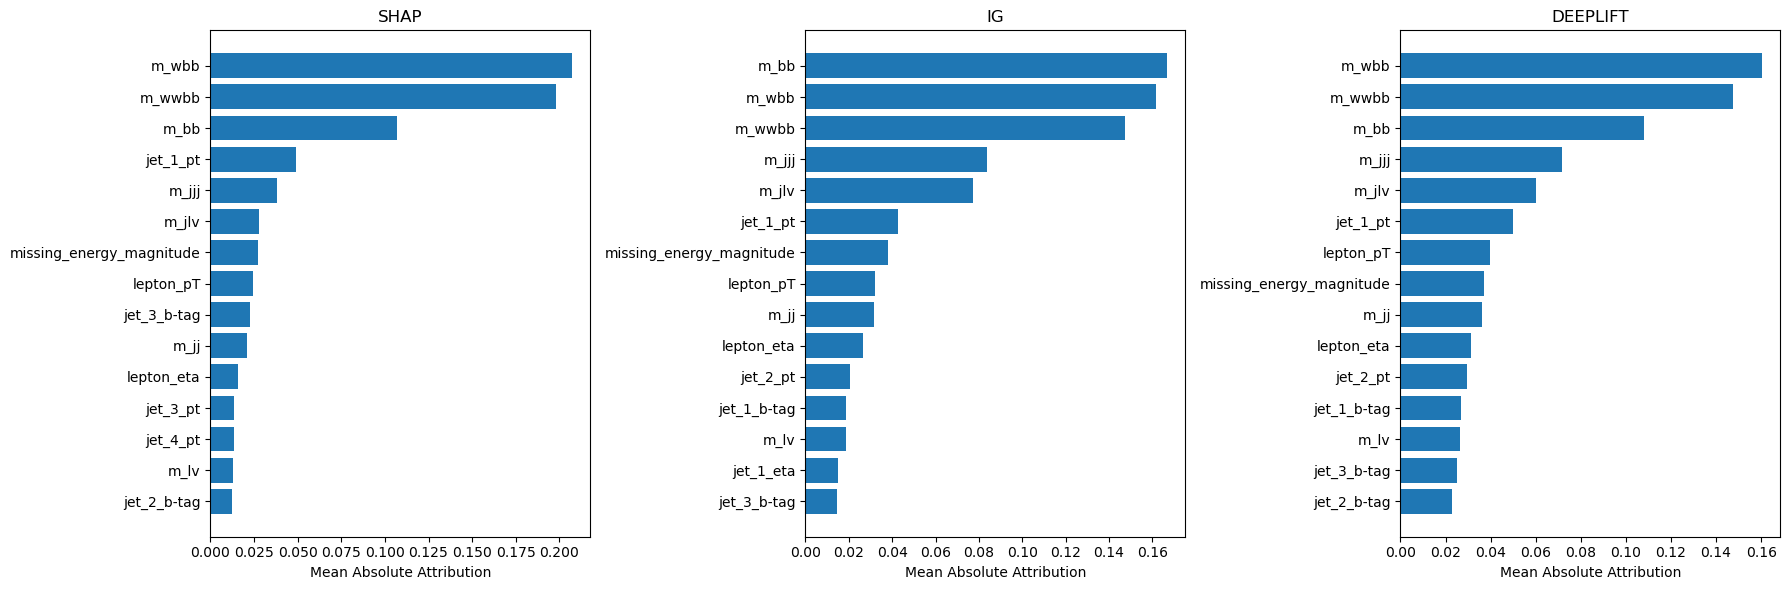

In [15]:
# Compare methods
comparison_results = xai_analyzer.compare_methods(
    X_background=X_train,
    X_test=X_test_subset[:100],  # Use smaller subset for faster computation
    methods=['shap', 'ig', 'deeplift'],
    save_path='../figures/xai_comparison.png'
)

## 6. Attribution Heatmap

Visualize attributions across multiple samples.

Input attributions shape: (50, 28, 1)
Detected 3D attributions: (50, 28, 1)
Squeezed to 2D: (50, 28)
Final 2D shape: (50, 28)
Plotting heatmap: (20, 28) with 28 features
Heatmap saved to ../figures/attribution_heatmap.png


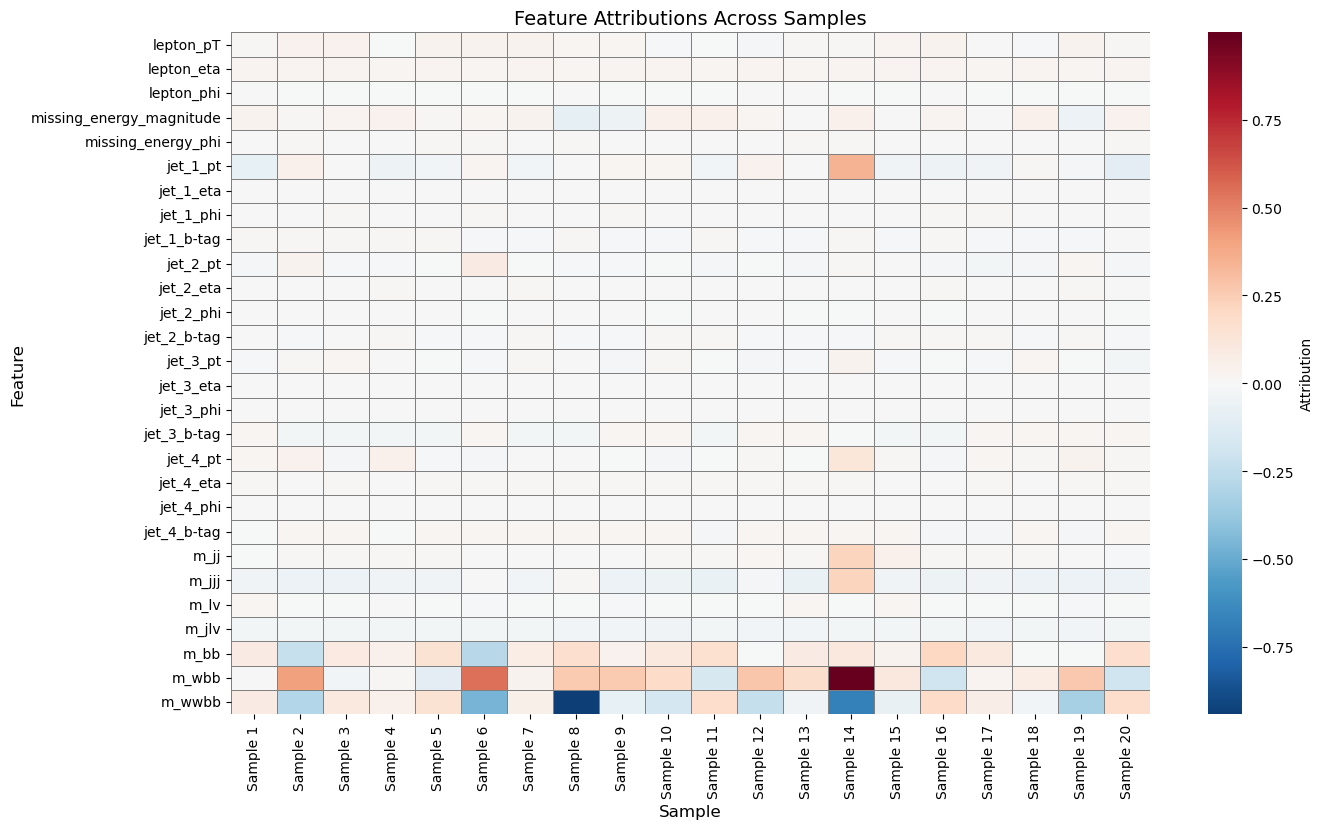

In [16]:
# Plot attribution heatmap for SHAP values
plot_attribution_heatmap(
    shap_values[:50],  # First 50 samples
    feature_names,
    n_samples=20,
    save_path='../figures/attribution_heatmap.png'
)

## 7. Feature Importance Ranking

Compare feature rankings across different XAI methods.

In [17]:
import pandas as pd

# Print shapes to debug
print(f"SHAP values shape: {shap_values.shape}")
print(f"IG attributions shape: {ig_attributions.shape}")
print(f"DeepLIFT attributions shape: {deeplift_attributions.shape}")

# Handle 3D shapes - squeeze and/or flatten
if len(shap_values.shape) == 3:
    shap_values_2d = shap_values.squeeze(-1) if shap_values.shape[-1] == 1 else shap_values.reshape(shap_values.shape[0], -1)
else:
    shap_values_2d = shap_values

if len(ig_attributions.shape) == 3:
    ig_attributions_2d = ig_attributions.squeeze(-1) if ig_attributions.shape[-1] == 1 else ig_attributions.reshape(ig_attributions.shape[0], -1)
else:
    ig_attributions_2d = ig_attributions

if len(deeplift_attributions.shape) == 3:
    deeplift_attributions_2d = deeplift_attributions.squeeze(-1) if deeplift_attributions.shape[-1] == 1 else deeplift_attributions.reshape(deeplift_attributions.shape[0], -1)
else:
    deeplift_attributions_2d = deeplift_attributions

# Calculate mean absolute attributions for each method (now 1D)
shap_importance = np.abs(shap_values_2d).mean(axis=0)
ig_importance = np.abs(ig_attributions_2d).mean(axis=0)
deeplift_importance = np.abs(deeplift_attributions_2d).mean(axis=0)

print(f"\nSHAP importance shape: {shap_importance.shape}")
print(f"IG importance shape: {ig_importance.shape}")
print(f"DeepLIFT importance shape: {deeplift_importance.shape}")

# Handle time series case - expand feature names if needed
if shap_importance.shape[0] > len(feature_names):
    n_timesteps = shap_importance.shape[0] // len(feature_names)
    expanded_feature_names = [f"{name}_t{t}" for t in range(n_timesteps) for name in feature_names]
else:
    expanded_feature_names = feature_names

# Ensure all arrays are the same length
min_length = min(len(expanded_feature_names), shap_importance.shape[0], 
                 ig_importance.shape[0], deeplift_importance.shape[0])

# Create DataFrame
importance_df = pd.DataFrame({
    'Feature': expanded_feature_names[:min_length],
    'SHAP': shap_importance[:min_length],
    'Integrated Gradients': ig_importance[:min_length],
    'DeepLIFT': deeplift_importance[:min_length]
})

# Sort by SHAP importance
importance_df = importance_df.sort_values('SHAP', ascending=False)

print("\nTop 15 Most Important Features:")
print(importance_df.head(15).to_string(index=False))

SHAP values shape: (500, 28, 1)
IG attributions shape: (500, 28)
DeepLIFT attributions shape: (500, 28)

SHAP importance shape: (28,)
IG importance shape: (28,)
DeepLIFT importance shape: (28,)

Top 15 Most Important Features:
                 Feature     SHAP  Integrated Gradients  DeepLIFT
                  m_wwbb 0.197527              0.138984  0.139665
                   m_wbb 0.193544              0.153821  0.158037
                    m_bb 0.094398              0.170663  0.113769
                jet_1_pt 0.054649              0.048781  0.055422
                   m_jjj 0.051551              0.072397  0.065068
                   m_jlv 0.033544              0.075282  0.064401
missing_energy_magnitude 0.028977              0.035439  0.036464
               lepton_pT 0.023044              0.036443  0.042899
              lepton_eta 0.020654              0.024373  0.031805
             jet_3_b-tag 0.020543              0.013820  0.022598
                jet_2_pt 0.019485              

## Summary

This notebook demonstrated various XAI methods for explaining Higgs boson classification:

1. **SHAP**: Provides global feature importance and individual explanations
2. **LIME**: Explains individual predictions with local interpretable models
3. **Integrated Gradients**: Attributes predictions through gradient integration
4. **DeepLIFT**: Compares activations to reference values

All methods help understand which features are most important for distinguishing signal from background events.